In [1]:
import random
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split

from torch.utils.data.dataset import Dataset

import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
np.random.seed(1)
random.seed(1)

data = np.load('data/RESISC45_images_96.npy')
labels = np.load('data/RESISC45_classes.npy')

test_size = 0.25
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size = test_size, stratify = labels)


np.save('data/RESISC45_images_train.npy', xtrain)
np.save('data/RESISC45_labels_train.npy', ytrain)
np.save('data/RESISC45_images_test.npy', xtest)
np.save('data/RESISC45_labels_test.npy', ytest)


In [3]:
train_data = np.load('data/RESISC45_images_train.npy')
train_labels = np.load('data/RESISC45_labels_train.npy')
classes = np.load('data/RESISC45_class_names.npy')

print('Training data shape: ', train_data.shape)
print('Testing data shape: ', train_labels.shape)
print('Num Classes', classes.shape)

Training data shape:  (23625, 96, 96, 3)
Testing data shape:  (23625,)
Num Classes (45,)


In [4]:
img_size = train_data.shape[2]# can use this to mofidy data size to fit this model (which only takes 256 images)
n_epochs = 30 # 25+ needed. just keep raising this number...
print_stride = n_epochs // 15
bs = 32 # 64

z_dim = 250
c_dim = classes.shape[0]

print(img_size)

96


In [5]:
xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = 0.25)

xtrain = torch.tensor(xtrain).permute(0,3,1,2)
print(torch.min(xtrain), torch.max(xtrain))

trainset = []
for i in range(xtrain.shape[0]):
    trainset.append((xtrain[i], ytrain[i]))
    
train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=False) #BUG: must keep shuffle false - or else it screws up labels, apparently

## Validation Data
valset = []
xval = torch.tensor(xval).permute(0,3,1,2)

print(torch.min(xval), torch.max(xval))
for i in range(xval.shape[0]):
    valset.append((xval[i], yval[i]))

val_loader = torch.utils.data.DataLoader(valset, batch_size=64, drop_last = True,
                                          shuffle=False) #BUG: must keep shuffle false - or else it screws up labels, apparently

test_data = np.load('data/RESISC45_images_test.npy')
test_labels = np.load('data/RESISC45_labels_test.npy')

test_data = torch.tensor(test_data)
test_labels = torch.tensor(test_labels)
## Testing Data
testset = []
print(test_data.shape)
xtest = torch.tensor(test_data).permute(0,3,1,2)
print(xtest.shape)

print(torch.min(test_data), torch.max(test_data))
for i in range(test_data.shape[0]):
    testset.append((test_data[i], test_labels[i]))

test_loader = torch.utils.data.DataLoader(testset, batch_size=64, drop_last = True,
                                          shuffle=False) #BUG: must keep shuffle false - or else it screws up labels, apparently



tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
torch.Size([7875, 96, 96, 3])
torch.Size([7875, 3, 96, 96])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


<ipython-input-5-c44b232db32c>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtest = torch.tensor(test_data).permute(0,3,1,2)


Shape of a batch of images:
torch.Size([32, 3, 96, 96])
Shape of a batch of labels:
torch.Size([32])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
17
harbor


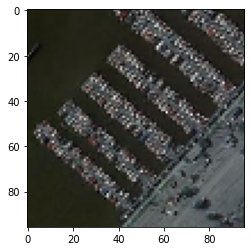

In [6]:
print('Shape of a batch of images:')
print(next(iter(train_loader))[0].shape)
print('Shape of a batch of labels:')
print(next(iter(train_loader))[1].shape)

first_samp = next(iter(train_loader))[0][0] #get first sample in first batch
print(torch.min(first_samp), torch.max(first_samp)) #images naturally (0,255)
plt.imshow(first_samp.permute(1,2,0)/255) #show it

name = next(iter(train_loader))[1][0].data.item()
print(name)
print(classes[name]) 

In [11]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        ## Encoding: Unconditional samples
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (bs, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        #self.conv7 = nn.Conv2d(2048, z_dim, 4, 2, 0) # Output: (bs, c_dim, 1, 1)
        self.fce = nn.Linear(1024, 45)

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        #m.bias.data.zero_()

def one_hot_embedding(labels):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
    return torch.squeeze(labels)

def accuracy(output, target, topk=(5,)):
    #https://gist.github.com/weiaicunzai/2a5ae6eac6712c70bde0630f3e76b77b
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [12]:
CNN = Conv_Pred()
CNN.weight_init()
CNN.to(device)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
learning_rate = 0.0008

augmentations = True

CNN_optimizer = optim.Adam(CNN.parameters(),
                         lr = learning_rate)
                         #betas = (beta_1, beta_2))
    
augmentation_list = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3, fill=0.5),
        transforms.RandomAffine(180)
        #transforms.ColorJitter(saturation=0.2, hue=0.01),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])

In [13]:
CNN_loss_tracker = []
for epoch in range(1, n_epochs+1):

    CNN_losses = []

    for X, y in train_loader:
        #print(torch.min(X), torch.max(X))
        mini_batch = X.size()[0]
        X = X.to(device).float()
        X = 2.0*(X/255 - 0.5)
        y = one_hot_embedding(y.to(device)).float()
        
        if augmentations == True:
            X = augmentation_list(X)

        ## CNN Training
        for param in CNN.parameters():
            param.grad = None

        yhat = CNN(X)
        pred_loss = bce_loss(yhat, y)
        
        model_loss = pred_loss

        model_loss.backward()
        CNN_optimizer.step()

        CNN_losses.append(pred_loss.data.item())
        

    if epoch % print_stride == 0:
        print('Epoch {} - loss_CNN: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(CNN_losses))))

        CNN_loss_tracker.append(torch.mean(torch.FloatTensor(CNN_losses)))
        
        with torch.no_grad():
            topks = []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                #print(x, y)
                yhat = CNN(x)
                
                yhat = torch.max(yhat, dim = 1)[1]
                #print(yhat.shape)
                
                correct = torch.sum(yhat == y)
                size = x.shape[0]
                
                topks.append((correct/size).data.item())
                
            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())
                


<ipython-input-11-e0e78e563d29>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)


Epoch 2 - loss_CNN: 0.065
Validation Accuracy:  0.22995923459529877
Epoch 4 - loss_CNN: 0.047
Validation Accuracy:  0.24575407803058624
Epoch 6 - loss_CNN: 0.038
Validation Accuracy:  0.22860054671764374
Epoch 8 - loss_CNN: 0.032
Validation Accuracy:  0.2501698434352875
Epoch 10 - loss_CNN: 0.027
Validation Accuracy:  0.28651493787765503
Epoch 12 - loss_CNN: 0.024
Validation Accuracy:  0.24898098409175873
Epoch 14 - loss_CNN: 0.021
Validation Accuracy:  0.29653531312942505
Epoch 16 - loss_CNN: 0.018
Validation Accuracy:  0.31368884444236755
Epoch 18 - loss_CNN: 0.016
Validation Accuracy:  0.2484714686870575
Epoch 20 - loss_CNN: 0.014
Validation Accuracy:  0.23811140656471252
Epoch 22 - loss_CNN: 0.012
Validation Accuracy:  0.2890625
Epoch 24 - loss_CNN: 0.010
Validation Accuracy:  0.2992527186870575
Epoch 26 - loss_CNN: 0.009
Validation Accuracy:  0.3062160313129425
Epoch 28 - loss_CNN: 0.008
Validation Accuracy:  0.346807062625885
Epoch 30 - loss_CNN: 0.006
Validation Accuracy:  0.316

In [ ]:
xy = next(iter(val_loader))
x = xy[0].to(device).float()
y = xy[1]

yhat = CNN(x)
print(yhat.shape)
res = torch.topk(yhat, 3, dim = 1)
print(res[1].shape)



accuracy(yhat.to(device), y.to(device), topk=(5,))

In [ ]:
plt.plot(CNN_loss_tracker)
torch.save(CNN.state_dict(), f'aug_{augmentations}_epo_{n_epochs}_tsize_{test_size}_CNN.pt')

In [ ]:
print(yhat)
torch.mean(torch.FloatTensor(topks)).data.item()

In [ ]:
# Embed Train set points:
embedded_points = []
labels = []

AE = AE.eval()

with torch.no_grad():
    for x,y in train_loader:
        #if x.shape[0] < bs:
        #    break
        x = 2*((x / 255) - 0.5)
        x = AE.encode(x.to(device)).squeeze()
        if x.shape[0] == 54:
            break
        #print(x.shape)
        embedded_points.append(x)
        labels.append(y)
        
#print(len(embedded_points))
#print(embedded_points[0].shape)
#print(embedded_points[-1].shape)
embedded_points = embedded_points[:-1] #skip last bad shape
labels = labels[:-1]
train_embedded = torch.cat(embedded_points, dim=0)
train_y = torch.cat(labels, dim = 0)
print('train set shape:')
print(train_embedded.shape)
print(train_y.shape)

# Embed Validation set points:
embedded_points = []
labels = []

with torch.no_grad():
    for x,y in val_loader:
        x = 2*((x / 255) - 0.5)
        
        x = AE.encode(x.to(device))
        #print(x.shape)
        embedded_points.append(x)
        labels.append(y)
        
val_embedded = torch.stack(embedded_points).squeeze()
val_y = torch.stack(labels).squeeze()
print('validation set shape: ', val_embedded.shape)
print(val_y.shape)

# Embed test set points:
embedded_points = []
labels = []

print(next(iter(test_loader))[0].shape)

with torch.no_grad():
    for x,y in test_loader:
        x = x.permute(0,3,1,2)
        
        x = 2*((x / 255) - 0.5)
        
        x = AE.encode(x.to(device))
        #print(x.shape)
        embedded_points.append(x)
        labels.append(y)
        
test_embedded = torch.stack(embedded_points).squeeze()
test_y = torch.stack(labels).squeeze()
print('test set shape:')
print(test_embedded.shape)
print(test_y.shape)

In [ ]:
# Gridsearch using training set on validation set

import torch
import sklearn
from sklearn import tree, ensemble, neighbors, neural_network
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


n_samples = 1000
print('==============================')

train_data = train_embedded.cpu()[0:n_samples]
val_data = val_embedded.cpu()[0:n_samples]

train_y = train_y[0:n_samples]
val_y = val_y[0:n_samples]

print('train_data.shape', train_data.shape)

print('test_data shape', val_data.shape)

print(train_y.shape, val_y.shape)

if True:
    ## RandomForestClassifier
    model = sklearn.ensemble.RandomForestClassifier()
    parameters = {'n_estimators':(range(2,503, 50)), 
                  'max_depth':(range(3,10,1)), 
                  'min_samples_leaf':(range(2,8,2))}
    clf = GridSearchCV(model, parameters)
    clf.fit(train_data, train_y)
    print('RFC: ', clf.best_params_)
    best = clf.best_params_
    Tmodel = sklearn.ensemble.RandomForestClassifier(n_estimators = best['n_estimators'],
                                                    max_depth = best['max_depth'],
                                                    min_samples_leaf = best['min_samples_leaf'])

    Tmodel.fit(train_data, train_y)
    y_pred = Tmodel.predict(val_data)

if False:
    ## K Neighbors Regressor
    model = sklearn.neighbors.KNeighborsClassifier(algorithm = 'auto')
    parameters = {'n_neighbors':(range(2,12)), 
                  'weights':('uniform', 'distance'), 
                  'leaf_size':(range(2,63,10))}
    clf = GridSearchCV(model, parameters)
    clf.fit(train_data, train_y)
    print('K-Neighbors Regressor: ', clf.best_params_)
    best = clf.best_params_
    Tmodel = sklearn.neighbors.KNeighborsClassifier(algorithm = 'auto',
                                                    n_neighbors = best['n_neighbors'],
                                                    weights = best['weights'],
                                                    leaf_size = best['leaf_size'])

    Tmodel.fit(train_data, train_y)
    y_pred = Tmodel.predict(val_data)


In [ ]:
from latent_predictor import fit_optim_predictor
clf, final = fit_optim_predictor(train_embedded, train_y, val_embedded, val_y)

In [ ]:
val_acc = sklearn.metrics.accuracy_score(val_y, y_pred)
#f1_score = sklearn.metrics.f1_score(val_y, y_pred, average = 'samples')
top_5 = sklearn.metrics.classification_report(val_y, y_pred)
#pscore = sklearn.metrics.precision_score(val_y, y_pred)
print('Val Acc: ', val_acc)
print(top_5)